In [1]:
"""
Downloading VIIRS Active Fire Detections (AFD) with 'earthaccess' python API

For a given geometry (in this case, fire perimeters), download data granules for:

VIIRS/NPP Active Fires 6-Min L2 Swath 375m V002 (VNP14IMG)
VIIRS/NPP Imagery Resolution Terrain Corrected Geolocation 6-Min L1 Swath 375 m (VNP03IMG)

Return: 
    - Downloaded NetCDF granules for the above products
    - GeoDataFrame representing active fire pixel locations and attributes (before geolocation)
    - Geolocation grid representing pixel locations and overlap of adjacent orbits

Author: maxwell.cook@colorado.edu
"""

import sys, os
import earthaccess
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import math
import contextlib
import traceback
import datetime as dt
import xarray as xr
import pyproj

from netCDF4 import Dataset 
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from affine import Affine
from osgeo import gdal, gdal_array, gdalconst, osr
from rasterio.transform import from_bounds
from scipy.spatial import cKDTree

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Directories
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

# Output directories
dataraw = os.path.join(projdir,'data/spatial/raw/VIIRS/')
datamod = os.path.join(projdir,'data/spatial/mod/VIIRS/')

print("Ready !")

Ready !


In [2]:
# Load the lookup table for pixel sizes
fp = os.path.join(projdir,'data/tabular/raw/pix_size_lut.csv')
lut = pd.read_csv(fp)

In [3]:
class Download_VIIRS_AFD:
    """ Downloads VIIRS Active Fire Data (AFD) within a region for given date range """
    def __init__(self, start_date, last_date, geom = gpd.GeoDataFrame(),
                 fire_id_col = 'Fire_ID', fire_name_col = 'Fire_Name',
                 region_extent = None, # broader region to process granules
                 geog_crs = 'EPSG:4326', proj_crs = 'EPSG:5070',
                 short_names = ['VNP14IMG', 'VNP03IMG'], # active fire data and associated geolocation
                 buffer = None, out_directory=None, processed_granules=None
                ):
        """
        Args:
            - start_date: the intial date for the granule search
            - last_date: the final date for the granule search
            - gdf: GeoDataFrame for search request
            - geog_crs: Geographic projection (to retrieve coordinate pairs in lat/lon)
            - proj_crs: Projected coordinate system
            - short_names: the granules to be downloaded
            - buffer: Optional buffer for input geometry
        Returns:
            - Downloaded files (VIIRS Active Fire Data NetCDF and Geolocation information)
            - GeoDataFrame with non-geolocated (raw) fire detections
        """
        # Extract coordinate bounds
        self.coords, self.extent = get_coords(geom, buffer)
        print(f"Bounding extent for data search: \n{self.extent}\n")

        self.region = region_extent

        self.fire_id = geom[fire_id_col].iloc[0]
        self.fire_name = geom[fire_name_col].iloc[0]
        
        # Extract class attributes
        self.date_range = (str(start_date), str(last_date))
        self.geog_crs = geog_crs
        self.proj_crs = proj_crs
        self.short_names = short_names
        self.out_dir = out_directory

        self.processed_granules = processed_granules

    
    def ea_search_request(self):
        """ Generate an earthaccess search request with the given parameters """

        query = earthaccess.search_data(
            short_name=self.short_names, 
            polygon=self.coords,
            temporal=self.date_range, 
        )

        # Extract the query dataframe
        df = pd.json_normalize(query)
        # Grab a list of granule IDs
        granules = list(df['meta.native-id'].unique())

        # Filter the query to only download the "new" granules
        new = [g for g in granules if g not in self.processed_granules]
        query_ = [item for item in query if item['meta']['native-id'] in new]

        # Download the "new" granules
        earthaccess.download(query_, self.out_dir)
        
        # return fileset
        return df, granules
             

    def create_fire_gdf(self):
        """ Creates a geodataframe with active fire detections from a directory with NetCDF files """

        extent = self.region
        
        # Identify VNP14 vs. VNP03
        vnp14_files = list_files(self.out_dir, "VNP14IMG*.nc", recursive=True)
        vnp03_files = list_files(self.out_dir, "VNP03IMG*.nc", recursive=True)
        
        out_fire_dfs = []
        
        nprint = round(len(vnp14_files) / 4)
        
        for idx, fp in enumerate(sorted(vnp14_files)):
            
            # Gather some metadata information from the file name
            timestamp = fp.split('.')[1:3]
            year = timestamp[0][1:5]
            day = timestamp[0][5:8]
            time = timestamp[1]
            date = dt.datetime.strptime(year+day, '%Y%j').strftime('%b %d') 
            acq_date = dt.datetime.strptime(year+day, '%Y%j').strftime('%-m/%-d/%y') #match FIRMS
            daytime = int(time) > 1500 #timestamps in the 1900h-2200h UTC range are afternoon for Western US

            # Find matching geolocation data file for one record
            identifier = os.path.basename(fp)[:-3]
            parts = identifier.split('.') # split by '.'
            date_time_part = '.'.join(parts[1:4])  # Extract date-time parts for the VNP Version 002    
            geo_id = 'VNP03IMG' + '.' + date_time_part
            geo_da_fp = [geo_link for geo_link in vnp03_files if geo_id in os.path.basename(geo_link)][0] 
            
            if geo_da_fp is None:
                print(f"!!! No geolocation file found for: {identifier}")
                continue
            
            # Read the geolocation data
            with xr.open_dataset(geo_da_fp, engine='netcdf4', group='geolocation_data') as geo:
                i, j = np.indices(geo.longitude.shape) #line and sample
                # Crop to fire bounding extent
                scene = ((geo.longitude > extent[0]) & (geo.longitude < extent[1]) & 
                         (geo.latitude > extent[2]) & (geo.latitude < extent[3])).values

            # Get the VNP14IMG fire mask, etc
            with xr.open_dataset(fp, engine='netcdf4') as vnp14:
        
                qa = vnp14['algorithm QA']
                fire = vnp14['fire mask']
                daynight = vnp14.DayNightFlag #string Day or Night
                
                lonfp = vnp14.variables['FP_longitude'][:] # fire pixel longitude
                latfp = vnp14.variables['FP_latitude'][:]
                frp = vnp14.variables['FP_power'][:] # fire radiative power

                tree = cKDTree(np.array([lonfp, latfp]).T) #search tree for finding nearest FRP

            # Set up a pandas dataframe for the swath
            df = pd.DataFrame()
            df['longitude'] = list(geo.longitude.values[scene])
            df['latitude'] = list(geo.latitude.values[scene])
            df['fire_mask'] = list(fire.values[scene])
            df['daynight'] = daynight[0]
            df['confidence'] = df.fire_mask
            df.confidence = df.confidence.replace(
                {0:'x', 1:'x', 2:'x', 3:'x', 4:'x', 5:'x', 6:'x', 7:'l', 8:'n', 9:'h'})
            df['acq_date'] = acq_date
            df['acq_time'] = time
            df['j'] = list(j[scene]) #sample number for pixel size lookup
            
            # Retain only low-high confidence fire points
            df = df[df['fire_mask'] > 6]
            df['fire_mask'] = pd.Categorical(df['fire_mask'])
            known = df[df.confidence!='x'] # keep only low-high confidence fire pixels
            
            # gather frp
            for k in known.index:
                dist, nearest = tree.query([ known.loc[k, 'longitude'], known.loc[k, 'latitude'] ])
                df.loc[k, 'frp'] = frp[nearest].item()
        
            # Join to pixel size info
            df = pd.merge(df, lut, left_on='j', right_on='sample', how='left')
            df.drop(columns=['j'], inplace=True)
            out_fire_dfs.append(df)

            df['granule'] = identifier # add the identifier as the granule
        
            if idx % nprint == 0:
                print(f"Processed {idx+1} observations.")

            # Remove the netcdf files from the system and clear space

            del geo, vnp14
            # os.remove(geo_da_fp)
            # os.remove(fp)
        
        # Concatenate the out dfs
        fire_data = pd.concat(out_fire_dfs) # for the entire list of granules
        fire_data.to_csv(os.path.join(datamod,f'vnp14img_F{str(idx)}_{self.fire_id}_geo.csv'))
        
        return fire_data

print("Class and functions ready !")

Class and functions ready !


Index(['NA_L3CODE', 'NA_L3NAME', 'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE',
       'NA_L1NAME', 'NA_L3KEY', 'NA_L2KEY', 'NA_L1KEY', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')
Bounding Extent: 
[-109.71256442441098, -103.74104767380967, 35.186116191032376, 42.87216825857125]


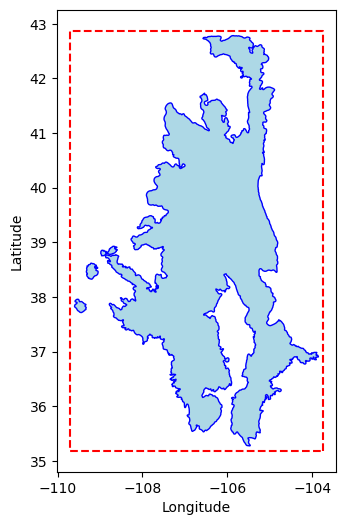

Bounding box saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/SRM_bounding_box.shp


In [4]:
# Create an extent around the Southern Rockies
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
srm = ecol3[ecol3['NA_L3NAME'] == 'Southern Rockies']
print(srm.columns)

buffer = 10000
srm_coords, srm_extent = get_coords(srm, buffer)
print(f"Bounding Extent: \n{srm_extent}")

# Unpack extent and create bounding box
minx, maxx, miny, maxy = srm_extent
bounding_box = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs="EPSG:4326")  # Assuming WGS84 geographic coordinates

# Plot the bounding box and SRM boundary
fig, ax = plt.subplots(figsize=(6, 6))

# Ensure SRM is in the correct CRS
srm_ = srm.to_crs('EPSG:4326')
srm_.plot(ax=ax, color="lightblue", edgecolor="blue", linewidth=1, label="SRM Boundary")
bbox_gdf.plot(ax=ax, color="none", edgecolor="red", linewidth=1.5, linestyle="--", label="Bounding Box")

# Customize the plot
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

# Export bounding box to shapefile
out_fp = os.path.join(projdir, "data/spatial/mod/SRM_bounding_box.shp")
bbox_gdf.to_file(out_fp)
print(f"Bounding box saved to: {out_fp}")

In [5]:
# Load the fire data

In [6]:
# Load the fire dataset for the Southern Rockies
fires_path = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen_SRM.gpkg')
fires = gpd.read_file(fires_path)
fires.rename(columns={'NIFC_ID': 'Fire_ID', 'NIFC_NAME': 'Fire_Name'}, inplace=True)
fires['DISCOVERY_DATE'] = fires['DISCOVERY_DATE'].dt.date
fires['WF_CESSATION_DATE'] = fires['WF_CESSATION_DATE'].dt.date
print(fires.columns)
len(fires)

Index(['Fire_ID', 'Fire_Name', 'NIFC_ACRES', 'FINAL_ACRES', 'pct_aspen',
       'INCIDENT_ID', 'INCIDENT_NAME', 'START_YEAR', 'CAUSE', 'DISCOVERY_DATE',
       'DISCOVERY_DOY', 'WF_CESSATION_DATE', 'WF_CESSATION_DOY',
       'STR_DESTROYED_TOTAL', 'STR_DAMAGED_TOTAL', 'STR_THREATENED_MAX',
       'EVACUATION_REPORTED', 'PEAK_EVACUATIONS', 'WF_PEAK_AERIAL',
       'WF_PEAK_PERSONNEL', 'na_l3name', 'geometry'],
      dtype='object')


31

In [7]:
# Testing with "large" fires
fires['NIFC_ACRES'] = fires['NIFC_ACRES'].astype(float)
fires['NIFC_ACRES'].describe()

count        31.000000
mean      44233.748065
std       73962.450028
min        1102.970000
25%        4343.480000
50%       13034.950000
75%       34491.665000
max      299792.600000
Name: NIFC_ACRES, dtype: float64

In [8]:
fires = fires[fires['NIFC_ACRES'] > 1500]
len(fires)

28

In [9]:
buffer = 10000 
srm_coords, srm_extent = get_coords(srm, buffer)
print(f"Bounding Extent: \n{srm_extent}")

Bounding Extent: 
[-109.71256442441098, -103.74104767380967, 35.186116191032376, 42.87216825857125]


In [10]:
t0 = time.time()

# Get a list of fire IDs
fire_ids = list(fires['Fire_ID'].unique())


afd_dfs = [] # to store the output geodataframes
granules_p = [] # to store processed granules
for fire_id in fire_ids[0:3]:
    t00 = time.time()

    print(fire_id)

    fire = fires[fires['Fire_ID'] == fire_id]
    start_dte = fire['DISCOVERY_DATE'].iloc[0]
    end_dte = fire['WF_CESSATION_DATE'].iloc[0]

    print(f"Processing for {fire['Fire_Name'].iloc[0]} Fire ...\n")
    
    # Initiate the download and extract class
    downloader = Download_VIIRS_AFD(
        start_date=start_dte,
        last_date=end_dte,
        geom=fire,
        region_extent=srm_extent,
        buffer=1000,
        short_names=['VNP14IMG','VNP03IMG'],
        out_directory=dataraw,
        processed_granules=granules_p # already processed
    )
    
    # Retrieve the search results
    try:
        # Download unique query
        query_df, granules = downloader.ea_search_request()
        granules_p.append(granules)
        
        # Create the active fire detection geodataframe
        print(f"\n\tGeolocating active fires ...\n")
        afd_fire = downloader.create_fire_gdf()
        afd_dfs.append(afd_fire_year)
        
        del afd_fire
        
    except Exception as e:
        print(f"Skipping fire {fire_id}\n{e}")
        traceback.print_exc()  # This will print the full traceback
        continue # continue to the next fire id

    t1 = (time.time() - t00) / 60
    print(f"Total elapsed time for {fire_year}: {t1:.2f} minutes.")
    print("\n~~~~~~~~~~\n")

# Concatenate the results and save out the geodataframe of latlon fire pixels (non-geolocated)
afds = pd.concat(afd_dfs, ignore_index=True)
afds.to_file(os.path.join(datamod,'vnp14img_SRM_aspen-fires_2018_to_2023_geo.gpkg'))

t2 = (time.time() - t0) / 60
print(f"Total elapsed time: {t2:.2f} minutes.")
print("\n~~~~~~~~~~\n")
print("Done!")

14
Processing for 416 Fire ...

Bounding extent for data search: 
[-108.0104287321153, -107.79428582032635, 37.37737010107216, 37.60899484292132]

Granules found: 188
 Getting 188 granules, approx download size: 15.17 GB


QUEUEING TASKS | :   0%|          | 0/188 [00:00<?, ?it/s]

File VNP03IMG.A2018152.0824.002.2021082143054.nc already downloaded
File VNP03IMG.A2018154.1906.002.2021082144544.nc already downloaded
File VNP03IMG.A2018154.2048.002.2021082144555.nc already downloaded
File VNP03IMG.A2018155.0906.002.2021082151024.nc already downloaded
File VNP03IMG.A2018155.2030.002.2021082150026.nc already downloaded
File VNP03IMG.A2018156.0848.002.2021082152013.nc already downloaded


PROCESSING TASKS | :   0%|          | 0/188 [00:00<?, ?it/s]

File VNP03IMG.A2018157.0830.002.2021082151852.nc already downloaded
File VNP03IMG.A2018157.1012.002.2021082151950.nc already downloaded
File VNP03IMG.A2018157.1954.002.2021082152531.nc already downloaded
File VNP03IMG.A2018158.0812.002.2021082152623.nc already downloaded
File VNP03IMG.A2018158.0954.002.2021082152645.nc already downloaded
File VNP03IMG.A2018158.1936.002.2021082153551.nc already downloaded
File VNP03IMG.A2018158.2112.002.2021082153557.nc already downloaded
File VNP03IMG.A2018159.0754.002.2021082154508.nc already downloaded
File VNP03IMG.A2018159.0936.002.2021082155020.nc already downloaded
File VNP03IMG.A2018159.1912.002.2021082154300.nc already downloaded
File VNP03IMG.A2018159.2054.002.2021082154852.nc already downloaded
File VNP03IMG.A2018160.0912.002.2021082155038.nc already downloaded
File VNP03IMG.A2018160.1854.002.2021082154829.nc already downloaded
File VNP03IMG.A2018160.2036.002.2021082155059.nc already downloaded
File VNP03IMG.A2018161.0854.002.2021082161041.nc

COLLECTING RESULTS | :   0%|          | 0/188 [00:00<?, ?it/s]


	Geolocating active fires ...

Processed 1 observations.
Skipping fire 14
[Errno -101] NetCDF: HDF error: '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/VIIRS/VNP03IMG.A2018156.0848.002.2021082152013.nc'
24
Processing for PLATEAU Fire ...

Bounding extent for data search: 
[-108.55759415978193, -108.38820426174999, 37.53276375842187, 37.68301700269862]



Traceback (most recent call last):
  File "/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 211, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/xarray/backends/lru_cache.py", line 56, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/VIIRS/VNP03IMG.A2018156.0848.002.2021082152013.nc',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False)), '19580ed7-c863-4c66-bd6d-a86c9eb35967']

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/ipykernel_3698/2620012170.py", line 40, in <module>
    afd_fire = downloader.create_fire_gdf()
  File "/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/

Granules found: 158
 Getting 158 granules, approx download size: 12.72 GB


QUEUEING TASKS | :   0%|          | 0/158 [00:00<?, ?it/s]

File VNP03IMG.A2018203.0906.002.2021090015245.nc already downloadedFile VNP03IMG.A2018205.0830.002.2021090030245.nc already downloaded
File VNP03IMG.A2018204.0848.002.2021090024900.nc already downloaded
File VNP03IMG.A2018203.2030.002.2021090023717.nc already downloaded
File VNP03IMG.A2018204.2012.002.2021090030016.nc already downloaded
File VNP03IMG.A2018205.1012.002.2021090032336.nc already downloaded
File VNP03IMG.A2018205.1954.002.2021090032252.nc already downloaded

File VNP03IMG.A2018206.0812.002.2021090033010.nc already downloaded
File VNP03IMG.A2018206.0954.002.2021090032907.nc already downloaded
File VNP03IMG.A2018207.0754.002.2021090035557.nc already downloaded
File VNP03IMG.A2018206.1936.002.2021090032931.nc already downloaded
File VNP03IMG.A2018206.2112.002.2021090042517.nc already downloaded
File VNP03IMG.A2018207.0936.002.2021090033407.nc already downloaded
File VNP03IMG.A2018208.2036.002.2022024130833.nc already downloaded
File VNP03IMG.A2018207.2054.002.2021090035116.nc

PROCESSING TASKS | :   0%|          | 0/158 [00:00<?, ?it/s]

File VNP03IMG.A2018226.2000.002.2021095144659.nc already downloadedFile VNP03IMG.A2018226.0836.002.2021095143917.nc already downloaded
File VNP03IMG.A2018225.2018.002.2021095143738.nc already downloaded
File VNP03IMG.A2018227.0818.002.2021095173834.nc already downloaded
File VNP03IMG.A2018222.1936.002.2021090220027.nc already downloaded
File VNP03IMG.A2018227.1000.002.2021095174822.nc already downloaded
File VNP03IMG.A2018227.1942.002.2021095175046.nc already downloaded

File VNP03IMG.A2018228.0800.002.2021095175303.nc already downloaded
File VNP03IMG.A2018222.2112.002.2021090220429.nc already downloaded
File VNP03IMG.A2018228.0942.002.2021095175327.nc already downloaded
File VNP03IMG.A2018228.1918.002.2021095175527.nc already downloaded
File VNP03IMG.A2018228.2100.002.2021095175549.nc already downloaded


COLLECTING RESULTS | :   0%|          | 0/158 [00:00<?, ?it/s]


	Geolocating active fires ...

Processed 1 observations.
Skipping fire 24
[Errno -101] NetCDF: HDF error: '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/VIIRS/VNP03IMG.A2018156.0848.002.2021082152013.nc'
46
Processing for QUARTZ RIDGE Fire ...

Bounding extent for data search: 
[-106.81670606370315, -106.69345936333454, 37.34216342133075, 37.39515273227939]



Traceback (most recent call last):
  File "/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 211, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/xarray/backends/lru_cache.py", line 56, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/VIIRS/VNP03IMG.A2018156.0848.002.2021082152013.nc',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False)), 'e8a972be-a5d9-44c4-8a14-4471812ccc65']

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/ipykernel_3698/2620012170.py", line 40, in <module>
    afd_fire = downloader.create_fire_gdf()
  File "/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/

Granules found: 200
 Getting 200 granules, approx download size: 16.25 GB


QUEUEING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

File VNP03IMG.A2023217.0912.002.2023223192200.nc already downloaded
File VNP03IMG.A2023217.2030.002.2023223194833.nc already downloaded
File VNP03IMG.A2023218.0854.002.2023223201702.nc already downloaded
File VNP03IMG.A2023218.2012.002.2023223205040.nc already downloaded
File VNP03IMG.A2023219.1954.002.2023223215705.nc already downloaded
File VNP03IMG.A2023220.0812.002.2023226155402.nc already downloaded
File VNP03IMG.A2023220.0954.002.2023226155350.nc already downloaded
File VNP03IMG.A2023220.1936.002.2023226155736.nc already downloaded
File VNP03IMG.A2023221.0754.002.2023221162005.nc already downloaded
File VNP03IMG.A2023221.0936.002.2023221162219.nc already downloaded
File VNP03IMG.A2023219.0830.002.2023223211923.nc already downloaded
File VNP03IMG.A2023221.1918.002.2023222021801.nc already downloaded
File VNP03IMG.A2023221.2054.002.2023222035458.nc already downloaded
File VNP03IMG.A2023222.0918.002.2023222155630.nc already downloaded
File VNP03IMG.A2023222.1900.002.2023223015432.nc

PROCESSING TASKS | :   0%|          | 0/200 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/200 [00:00<?, ?it/s]


	Geolocating active fires ...

Processed 1 observations.
Skipping fire 46
[Errno -101] NetCDF: HDF error: '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/VIIRS/VNP03IMG.A2018156.0848.002.2021082152013.nc'


Traceback (most recent call last):
  File "/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/xarray/backends/file_manager.py", line 211, in _acquire_with_cache_info
    file = self._cache[self._key]
  File "/opt/miniconda3/envs/aspen-fire/lib/python3.10/site-packages/xarray/backends/lru_cache.py", line 56, in __getitem__
    value = self._cache[key]
KeyError: [<class 'netCDF4._netCDF4.Dataset'>, ('/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/raw/VIIRS/VNP03IMG.A2018156.0848.002.2021082152013.nc',), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('persist', False)), 'b02571d4-f400-4c6d-a234-02f2ba7f0d20']

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/ipykernel_3698/2620012170.py", line 40, in <module>
    afd_fire = downloader.create_fire_gdf()
  File "/var/folders/lm/1zg27k9x385csjv9gkj8jqm80000gp/T/

ValueError: No objects to concatenate